---
## Import packages

In [30]:
!pip install art 
!pip install farasapy
!pip install Tashaphyne==0.3.4.1
!pip install wordcloud
!pip install ar_wordcloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from art import*
art= text2art ("Let 's     Go    !!!")
print(art)

 _            _     _             ____             _  _  _ 
| |      ___ | |_  ( ) ___       / ___|  ___      | || || |
| |     / _ \| __| |/ / __|     | |  _  / _ \     | || || |
| |___ |  __/| |_     \__ \     | |_| || (_) |    |_||_||_|
|_____| \___| \__|    |___/      \____| \___/     (_)(_)(_)
                                                           



In [31]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Gensim
import gensim, spacy, logging
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import string

import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.decomposition import LatentDirichletAllocation


from ar_wordcloud import ArabicWordCloud

In [4]:
from tashaphyne.stemming import ArabicLightStemmer

In [5]:
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

In [6]:
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.diacratizer import FarasaDiacritizer
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer

---
## Read and exploring the data

In [7]:
df = pd.read_csv('SaudiNews')
df.drop(columns= ['Unnamed: 0'], inplace= True)
df

,source,title,content
0,aleqtisadiya,هيئة المسح الجيولوجي الأمريكية: زلزال بقوة 6.3...,قالت هيئة المسح الجيولوجي الأمريكيةإن زلزالا ...
1,alweeam,توفر وظائف أكاديمية بجامعــة الملك فيصل,أعلنت جامعة الملك فيصل بالأحساء توفر عدد من ا...
2,sabq,&quot;أدبي جدة&quot; يدشن دورة &quot;مفاهيم كت...,سبق- جدة: دشَّن أدبي جدة اللقاء الأول من دورة...
3,alyaum,قتلة الطموح,«في مجتمعنا مبدأ يمنع تطور الفرد فكرياً واجتم...
4,alriyadh,دراسة مسببات عدم انخفاض السلع في المملكة بانخف...,أكد الدكتور سليمان السماحي الرئيس التنفيذي...
...,...,...,...
9995,okaz,تطويق العنف المدرسي ببرنامج «رفق» الإرشادي,تعتزم وزارة التعليم، في مستهل العام الدراسي ا...
9996,aawsat,ولي ولي العهد السعودي يتقبل بيعة منسوبي وزارة...,استقبل الأمير محمد بن سلمان بن عبد العزيز ولي ...
9997,alriyadh,هبوط أول طائرة عسكرية سعودية في مطار عدن بعد د...,هبطت طائرة عسكرية سعودية في مطار مدينة عدن...
9998,alwatan,"استثمار ""الربيعة"" عالميا",هناك دول في العالم تنفق مع شركات علاقات عالمي...


In [8]:
df = pd.read_csv('SaudiNews')
df.drop(columns= ['Unnamed: 0'], inplace= True)
df_sample=df.sample(n = 3000)

In [9]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 335 to 5322
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   source   3000 non-null   object
 1   title    2994 non-null   object
 2   content  2987 non-null   object
dtypes: object(3)
memory usage: 93.8+ KB


In [10]:
df_sample.duplicated().sum()

12

In [11]:
df_sample.drop_duplicates(inplace = True)

---
## NLP Preprocessing

In [12]:
max(df_sample.content.str.len())

18923.0

In [13]:
min(df_sample.content.str.len())

1.0

**removing observtions less than 120**

In [14]:
df_sample = df_sample[df_sample.content.str.len() > 120]

In [15]:
df_sample.shape

(2929, 3)

In [16]:
df_sample.content.isna().sum()

0

### **Removing Non-arabic letters, numbers, amiss typo and special characters**

In [17]:
# function to clean and normalize text 
def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']  
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
        
    text = text.strip()
    
    return text

In [18]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [19]:
# clean and normalize text
df_sample.content = df_sample.content.apply(lambda x: clean_text(x))

# remove punctuation
df_sample.content = df_sample.content.apply(lambda x: remove_punctuations(x))

# remove diacritics
df_sample.content = df_sample.content.apply(lambda x: remove_diacritics(x))

# remove repeating char
df_sample.content = df_sample.content.apply(lambda x: remove_repeating_char(x))

# remove english letters
df_sample.content = df_sample.content.apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

# remove a special character 
df_sample.content = df_sample.content.apply(lambda x: re.sub(r'[_]+', '', x))

# remove english numbers
df_sample.content = df_sample.content.apply(lambda x: re.sub(r'/[0-9\u0621-\u064A]+/u', '', x))

# remove space
df_sample.content = df_sample.content.apply(lambda x: re.sub(r'\d+', '', x))

In [20]:
df_sample

,source,title,content
335,alyaum,القيادة تهنئ رئيس المالديف بمناسبة ذكرى الاستقلال,بعث خادم الحرمين الشريفين الملك سلمان بن عبدال...
4535,aleqtisadiya,نائب الملك يصل عسير لتقديم العزاء في شهداء ا...,وصل نائب خادم الحرمين الشريفين الامير محمد بن ...
3811,aawsat,استمرار موجة خروج المستثمرين من الأسواق الناشئة,قال بنك اوف اميركا ميريل لينش امس الجمعه ان مس...
6004,alriyadh,أمانة الرياض تعتذر عن تجاوزات «ستاند آب» غير ا...,اكد ابراهيم الدعيلج مدير العلاقات العامه والاع...
9510,okaz,إحباط تهريب 176 كبسولة «هيروين» و«كوكايين»,احبط افراد الجمارك بمطار الملك عبدالعزيز الدول...
...,...,...,...
8987,alwatan,الأردن سابع محطات محمد بن سلمان,حطت طائره ولي ولي العهد النائب الثاني لرئيس مج...
1823,okaz,وصول طائرة الشحن الثانية الإغاثية لمطار عدن,انفاذا لتوجيهات خادم الحرمين الشريفين الملك سل...
3524,aljazirah,التوتر في بحر الصين الجنوبي يهيمن على القمة ال...,دعا دبلوماسيون من جنوب شرق اسيا الصين امس الثل...
6536,alriyadh,عايدني يا جاري..!,الاحسان لجار والتعامل الحسن معه يوثق روابط الا...


### **Stemming**

In [21]:
# st = ISRIStemmer()
# word_list = str(df_sample.content) # convert to string
# wordsfilter=[]
# # Define a function
# def filter(word_list):
    
#     for a in word_tokenize(word_list):
#         stem = st.stem(a)
#         wordsfilter.append(stem)
#     return wordsfilter

# # Call the function
# filter(word_list)

### **TF-IDF Vectorizer**

In [24]:
# the document-term matrix 
arb_stopwords = set(nltk.corpus.stopwords.words('arabic'))
tfidf = TfidfVectorizer(stop_words=arb_stopwords)
doc_words = tfidf.fit_transform(df_sample.content)
pd.DataFrame(doc_words.toarray(),columns=tfidf.get_feature_names())

,اؤدي,اؤكد,اؤلئك,اؤمن,اؤيد,اؤيدها,ائتلاف,ائتلافا,ائتلافيه,ائتمان,ائتمانيه,ائتمنه,ائمتهم,ائمه,اب,ابا,اباء,اباءنا,اباؤهم,ابائه,ابائهم,ابابا,اباتو,اباحسين,اباحي,اباحيه,اباد,اباده,ابار,ابارا,ابارك,اباغسطس,ابالخيل,ابالغ,ابالوس,ابان,ابانات,ابانت,اباه,ابت,...,يونانيه,يونايتد,يونج,يونس,يونسكو,يونغ,يونفيرستي,يونكر,يونهاب,يونيفرس,يونيفرسال,يونيفيرسال,يونيكريدت,يونيوحزيران,يونيون,يوهاندري,يوهاندي,يوهانس,يوهب,يوهمون,يوي,يويشي,يويو,کشف,کوارث,ﺍﺳﺘحدثهما,ﺍﺳﻤﻲ,ﺍﻟﺴﻴﺴﻲ,ﺍﻟﻠﺘﺎﻥ,ﺍﻟﻤﺼرين,ﺍﻻﺳﺘﺮﺍﺗﻴﺠﻲ,ﺑﺎﻟﺨﺎﺭﺝ,ﺑﻤستوي,ﺩﺭﺍﺳﺔ,ﻛﺎﻥ,ﻭﺍﻟﻤﺸروعات,ﻭﺯﻳري,ﻭﻫﻤﺎ,ﻷن,ﻹستقرار
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# To display full text
pd.set_option('display.max_colwidth',-1)#can see the whole data on one single row
# complaints_df
df_sample

source  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## EDA

downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


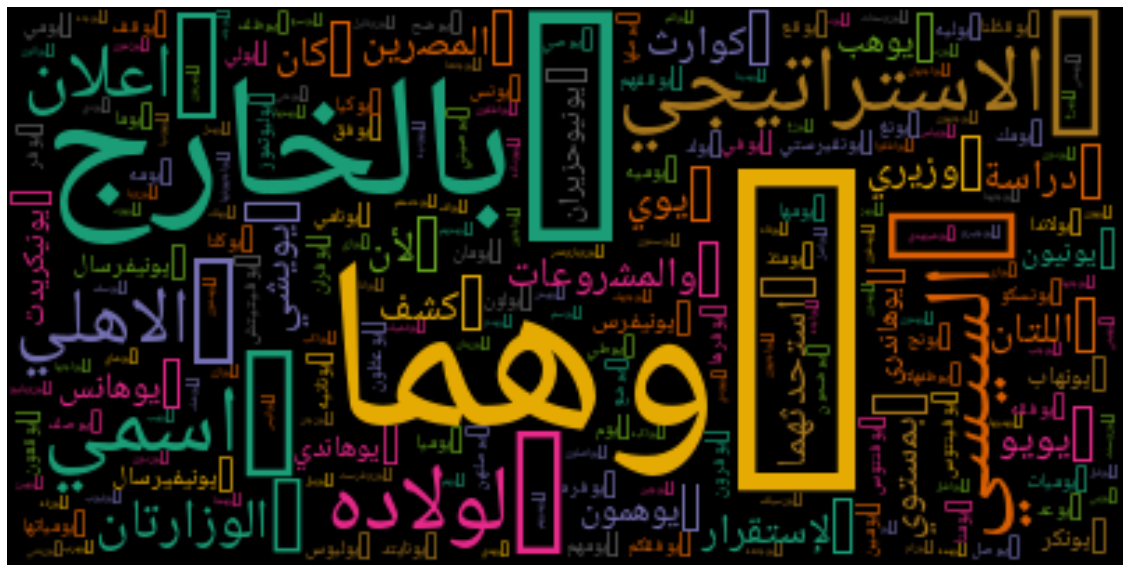

In [26]:
# print WordCloud visualization

awc = ArabicWordCloud(background_color="black",)

mpl.rcParams['figure.figsize']=(20,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

# wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(
#     str(tfidf.get_feature_names()))

wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(str(tfidf.get_feature_names()))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(colormap='Dark2'),interpolation='bilinear')
#plt.title("Word Cloud of all the words")
plt.axis('off');

count of source

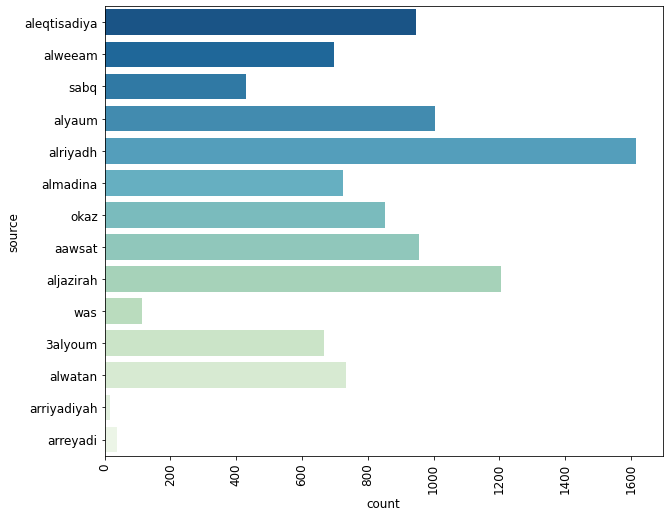

In [27]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.countplot(y="source", data=df, palette='GnBu_r');

source Distribution

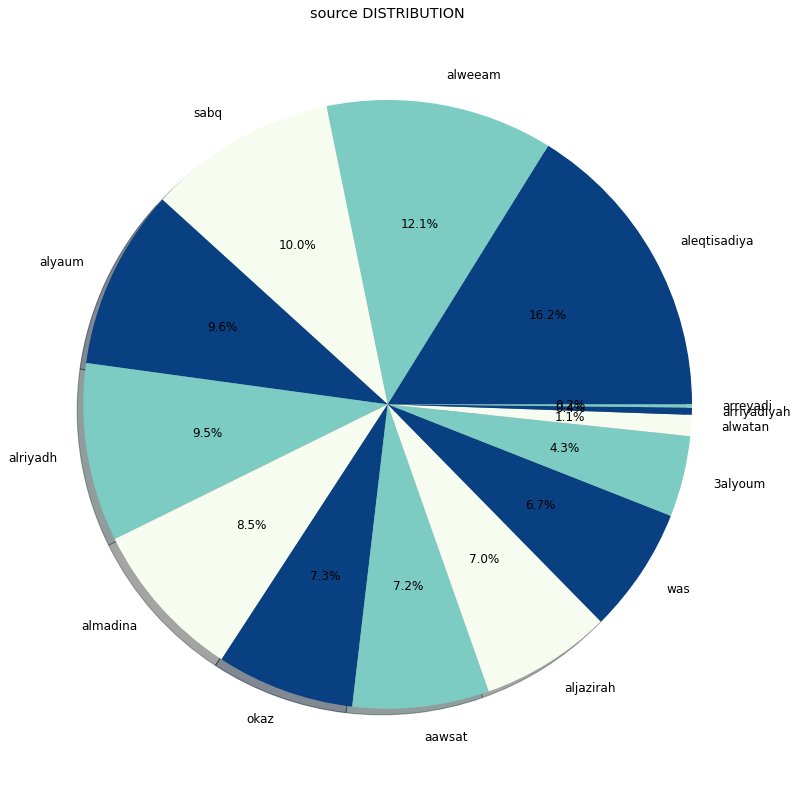

In [28]:
targetCounts = df['source'].value_counts()
targetLabels  = df['source'].unique()
# Make square figures and axes
plt.figure(1, figsize=(30,30))
the_grid = GridSpec(2, 2)

#Blues_r #PuBuGn #Sequential
cmap = plt.get_cmap('GnBu_r')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='source DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)

**Topic Modeling**


1. NMF

In [32]:
# function to display topics with words
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
#         else:
#             print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    

def display_top(model, feature_names, no_top_words, topic_names=None):
    
    my_dict = {'topic_0':'','topic_1':'','topic_2':'','topic_3':'','topic_4':''}
    ctr = 0
    for ix, topic in enumerate(model.components_):
                #if not topic_names or not topic_names[ix]:
#             print("\nTopic ", ix)
        txt = ",".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        my_dict['topic_'+str(ctr)] = txt
        ctr+=1
#         print('words are::: ',txt)
    return my_dict

In [33]:
topic_nums = list(np.arange(3, 10, 1))

#nmf_models = []
for num in topic_nums:
    nmf = NMF(num)
    #nmf_models.append(nmf)
    nmf.fit_transform(doc_words)
    display_topics(nmf, tfidf.get_feature_names(), 50)
    print("------------------------------------------")


Topic  0
ان, علي, الي, او, خلال, ايران, انه, العام, داعش, وقال, اي, المتحده, العمل, النفط, اكثر, حتي, كانت, تم, عد, الماضي, الا, عام, وفي, وزاره, عدن, اليوم, امس, الاتفاق, اله, السعوديه, وان, تنظيم, المائه, مليون, مليار, بنسبه, اسعار, المنطقه, شركه, بشكل, العالم, سوريا, دول, انها, فان, مدينه, بان, واضاف, الف, الملكه

Topic  1
بن, عبدالعزيز, ولي, الامير, سلمان, الملك, الحرمين, محمد, الشريفين, اله, خادم, الملكي, وزير, السمو, مجلس, العهد, سعود, الوزراء, صاحب, العربيه, الملكه, الدكتور, علي, عسير, رئيس, عبداله, ال, سموه, الدفاع, معالي, نائب, منطقه, السعوديه, خالد, نايف, جمهوريه, البلدين, امير, العامه, لرئيس, مدير, المركز, فيصل, النائب, الثاني, الانسانيه, مصر, حفظه, الشقيقين, الاستقبال

Topic  2
الفريق, النادي, علي, القدم, الاتحاد, الاعب, الموسم, الاعبين, نادي, لكره, الهلال, ان, السعودي, الاول, المدرب, المقبل, الفني, لاعب, السوبر, الاهلي, فريق, النصر, المباراه, مباراه, الي, اداره, كاس, الدوري, امام, المعسكر, الانديه, الاداره, التدريبات, الانجليزي, ملعب, مدرب, خلال, الملعب, دوري, الجهاز, الك

In [34]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_words)

In [35]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tfidf.get_feature_names())
topic_word

,اؤدي,اؤكد,اؤلئك,اؤمن,اؤيد,اؤيدها,ائتلاف,ائتلافا,ائتلافيه,ائتمان,ائتمانيه,ائتمنه,ائمتهم,ائمه,اب,ابا,اباء,اباءنا,اباؤهم,ابائه,ابائهم,ابابا,اباتو,اباحسين,اباحي,اباحيه,اباد,اباده,ابار,ابارا,ابارك,اباغسطس,ابالخيل,ابالغ,ابالوس,ابان,ابانات,ابانت,اباه,ابت,...,يونانيه,يونايتد,يونج,يونس,يونسكو,يونغ,يونفيرستي,يونكر,يونهاب,يونيفرس,يونيفرسال,يونيفيرسال,يونيكريدت,يونيوحزيران,يونيون,يوهاندري,يوهاندي,يوهانس,يوهب,يوهمون,يوي,يويشي,يويو,کشف,کوارث,ﺍﺳﺘحدثهما,ﺍﺳﻤﻲ,ﺍﻟﺴﻴﺴﻲ,ﺍﻟﻠﺘﺎﻥ,ﺍﻟﻤﺼرين,ﺍﻻﺳﺘﺮﺍﺗﻴﺠﻲ,ﺑﺎﻟﺨﺎﺭﺝ,ﺑﻤستوي,ﺩﺭﺍﺳﺔ,ﻛﺎﻥ,ﻭﺍﻟﻤﺸروعات,ﻭﺯﻳري,ﻭﻫﻤﺎ,ﻷن,ﻹستقرار
component_1,0.000,0.001,0.0,0.001,0.001,0.001,0.001,0.000,0.000,0.001,0.001,0.0,0.001,0.004,0.014,0.001,0.004,0.001,0.001,0.000,0.001,0.002,0.000,0.0,0.001,0.001,0.002,0.001,0.004,0.000,0.0,0.000,0.000,0.002,0.0,0.009,0.000,0.000,0.001,0.004,...,0.000,0.000,0.001,0.002,0.0,0.001,0.001,0.000,0.001,0.0,0.001,0.001,0.0,0.000,0.001,0.000,0.000,0.000,0.001,0.001,0.000,0.001,0.001,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_2,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.001,0.000,0.007,0.000,0.000,0.003,0.001,0.000,0.000,0.000,0.0,0.000,0.000,0.001,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.001,0.001,0.000,0.000,0.000,...,0.000,0.000,0.000,0.001,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_3,0.001,0.003,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.008,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.001,0.000,0.000,0.000,0.000,0.000,0.0,0.006,0.002,0.000,0.0,0.001,0.000,0.000,0.000,0.000,...,0.001,0.097,0.000,0.007,0.0,0.003,0.001,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.007,0.003,0.000,0.000,0.000,0.000,0.000,0.001,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_4,0.000,0.002,0.0,0.000,0.000,0.000,0.001,0.000,0.000,0.004,0.002,0.0,0.000,0.000,0.026,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.0,0.000,0.000,0.000,0.000,0.004,0.004,0.0,0.000,0.000,0.000,0.0,0.002,0.000,0.000,0.000,0.000,...,0.002,0.003,0.000,0.000,0.0,0.000,0.000,0.002,0.001,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_5,0.000,0.001,0.0,0.000,0.000,0.000,0.005,0.003,0.009,0.000,0.000,0.0,0.000,0.002,0.024,0.000,0.001,0.000,0.000,0.000,0.000,0.005,0.000,0.0,0.000,0.001,0.009,0.004,0.000,0.000,0.0,0.004,0.000,0.000,0.0,0.006,0.000,0.001,0.001,0.001,...,0.000,0.002,0.000,0.001,0.0,0.001,0.000,0.002,0.001,0.0,0.000,0.000,0.0,0.004,0.000,0.000,0.000,0.007,0.000,0.000,0.002,0.002,0.000,0.0,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.002,0.002


In [36]:
display_topics(nmf_model, tfidf.get_feature_names(), 50)



Topic  0
ان, علي, الي, او, العمل, خلال, انه, وزاره, تم, البلديه, العامه, الوزاره, اله, العام, الا, حتي, التعليم, اي, عد, الصحيه, وان, الاجتماعيه, الجنه, يكون, الملكه, اكثر, عام, الرياض, الخدمات, المجتمع, احد, وذلك, كانت, مدير, عبر, الدكتور, الشباب, يمكن, الانتخابيه, البرنامج, يتم, بشكل, وقد, الجهات, المكرمه, منطقه, السعوديه, اداره, جده, عليها

Topic  1
بن, عبدالعزيز, ولي, الامير, سلمان, الحرمين, الشريفين, الملك, محمد, الملكي, خادم, وزير, اله, السمو, مجلس, العهد, سعود, الوزراء, صاحب, العربيه, الملكه, رئيس, ال, الدكتور, عسير, عبداله, سموه, الدفاع, معالي, نائب, جمهوريه, نايف, علي, البلدين, السعوديه, خالد, منطقه, امير, الثاني, لرئيس, مصر, النائب, الشقيقين, فيصل, الانسانيه, المركز, الاستقبال, حفظه, امس, العلاقات

Topic  2
الفريق, النادي, القدم, علي, الاتحاد, الاعب, الموسم, الاعبين, نادي, لكره, الهلال, ان, السعودي, المدرب, الاول, المقبل, الفني, لاعب, السوبر, الاهلي, النصر, فريق, مباراه, المباراه, كاس, الي, الدوري, اداره, امام, المعسكر, الانديه, الاداره, الانجليزي, التدريبات, ملعب, مدرب, الم

2. LDA

In [40]:
# Define Search Param
search_params = {'n_components': [10, 9, 8, 7, 6, 5, 4, 3], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_words)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_words))

In [ ]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_words)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics